<a href="https://colab.research.google.com/github/AgarwalMayank2/Face_Detection/blob/main/applying_ML_algorithms/Decision_Tree_PRMLproj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task : Identify Face in image using Decision Tree algorithm
dataset : using processed dataset

we extracted CNN(ResNet), HoG, LBP features and made these processed datasets

processed datasets : https://github.com/AgarwalMayank2/Face_Detection/tree/main/processed_dataset


# Decision Tree algorithm


In [1]:
import numpy as np

def entropy(labels):
    """Compute entropy of the data with labels."""
    # YOUR CODE HERE
    unique_labels, freq = np.unique(labels, return_counts=True)
    prob = freq / len(labels) # prob = probability array of elements
    entropy = -np.sum(prob * np.log2(prob))
    return entropy

def compute_information_gain(data, feature_index, labels):
    """
    Computes information gain of a feature for a given dataset.

    Parameters:
    data (np.array): Feature matrix of shape (n_samples, n_features)
    feature_index (int): Index of the feature to compute IG
    labels (list or np.array): List of class labels

    Returns:
    float: Information gain
    """
    sum=np.sum(data,axis=0)
    thresh=sum[feature_index]/data.shape[0] #mean of given features #answer for Q8
    split1=[]
    split2=[]
    for i, point in enumerate(data):
        if point[feature_index]<=thresh:
            split1.append(labels[i])
        else:
            split2.append(labels[i])
    split1=np.array(split1)
    split2=np.array(split2)
    info_gain=entropy(labels)-(len(split1)/len(labels))*entropy(split1)-(len(split2)/len(labels))*entropy(split2)
    return info_gain,thresh

def best_split(data, labels):
    """Find the best feature and threshold for splitting."""
    best_info_gain = -1
    best_feature = None
    best_threshold = None
    for feature_index in range(data.shape[1]):
        info_gain, threshold = compute_information_gain(data, feature_index, labels)
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature = feature_index
            best_threshold = threshold
    return best_feature, best_threshold
    # YOUR CODE HERE
    raise NotImplementedError()

In [2]:
class DecisionTreeNode:
    """Class for a decision tree node."""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.root = None

    def fit(self, data, labels, depth=0):
        """Recursively builds the decision tree."""
        # Base case: Stop splitting if pure or max depth reached
        if depth == self.max_depth or len(np.unique(labels)) == 1: #Why?
            return DecisionTreeNode(value=np.bincount(labels).argmax()) #Why?

        # Find best feature and threshold
        best_feature, best_threshold = best_split(data, labels)

        # Partition data
        left_mask = data[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        if np.all(left_mask) or np.all(right_mask):  # Prevent infinite splitting
            return DecisionTreeNode(value=np.bincount(labels).argmax())

        left_child = self.fit(data[left_mask], labels[left_mask], depth + 1)
        right_child = self.fit(data[right_mask], labels[right_mask], depth + 1)

        return DecisionTreeNode(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)

    def train(self, data, labels):
        """Initialize tree training."""
        self.root = self.fit(data, labels, depth=0)

In [3]:
def predict_sample(node, sample):
    """Recursively predict the label for a single sample."""
    if node.value is not None:
        return node.value
    if sample[node.feature] <= node.threshold:
        return predict_sample(node.left, sample)
    else:
        return predict_sample(node.right, sample)

def predict(tree, data):
    """Predict labels for multiple samples."""
    return np.array([predict_sample(tree.root, sample) for sample in data])



# Decision Tree on CNN features with LDA

## Loading filtered_CNN_features_dataset and filtering on basis of count of images per person

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [5]:
url_filtered_CNN_features_dataset = 'https://raw.githubusercontent.com/AgarwalMayank2/Face_Detection/refs/heads/main/processed_dataset/filtered_CNN_features_dataset.csv' #for CNN limited
df_CNN = pd.read_csv(url_filtered_CNN_features_dataset) # reading url for extracted CNN_features_dataset_limited.csv
df_CNN.drop('Unnamed: 0', axis=1, inplace=True)

#dropping those labels whose number of datapoints are less than 80
# Get the counts of each label
label_counts = df_CNN['2048'].value_counts()

# Filter out labels with counts less than 80
labels_to_keep = label_counts[label_counts >= 80].index

# Filter the DataFrame
df_CNN = df_CNN[df_CNN['2048'].isin(labels_to_keep)]

df_CNN


,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
207,0.334396,1.031447,0.751403,0.061664,1.358539,0.131194,2.189165,0.168872,0.077561,0.128026,...,0.238129,0.033446,0.691363,1.453779,0.023197,1.180975,0.147620,0.132144,0.061259,Donald_Rumsfeld
208,0.052159,1.385429,0.948584,0.242452,0.765526,0.205163,2.773744,0.487321,0.375770,0.297134,...,0.151970,0.030394,0.931749,1.507545,0.074761,1.410434,0.187171,0.037343,0.192220,Donald_Rumsfeld
209,0.215924,1.243201,1.040831,0.082872,0.996569,0.093324,3.699462,0.166822,0.085976,0.420676,...,0.280522,0.046874,0.933633,1.932075,0.076832,1.779623,0.345520,0.009288,0.176782,Donald_Rumsfeld
210,0.273529,1.568788,1.131568,0.069734,1.060217,0.003534,3.313872,0.470634,0.280771,0.550614,...,0.392776,0.303419,0.718607,1.815761,0.034294,1.519493,0.046060,0.031623,0.141197,Donald_Rumsfeld
211,0.209844,1.102461,0.380182,0.109593,0.713786,0.054662,2.087155,0.206262,0.103134,0.152454,...,0.100046,0.225041,0.373597,0.834548,0.102522,0.784862,0.023190,0.141059,0.058093,Donald_Rumsfeld
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3959,0.312240,1.009504,0.836836,0.018082,0.645396,0.066804,2.271123,0.094211,0.141208,0.130362,...,0.292594,0.216060,0.466659,0.785201,0.021710,0.663016,0.343248,0.060820,0.134825,Colin_Powell
3960,0.318314,1.077076,0.959523,0.018094,0.547238,0.033101,2.574726,0.171667,0.403900,0.141492,...,0.184252,0.081133,0.731656,1.326214,0.040101,1.001839,0.011269,0.099451,0.093939,Colin_Powell
3961,0.344084,0.716365,1.162212,0.025244,1.336606,0.032508,3.778199,0.205079,0.106398,0.161860,...,0.078263,0.198066,0.789224,1.613293,0.019929,1.323015,0.041566,0.020037,0.051515,Colin_Powell
3962,0.349864,0.792629,0.792507,0.079453,1.206452,0.083974,2.950798,0.072012,0.180612,0.077492,...,0.130345,0.346125,0.530768,1.389377,0.117860,1.205199,0.044289,0.032452,0.238427,Colin_Powell


## Splitting dataframe into train, validation and test in 4:1 ratio

In [6]:
# Separate features and labels
X = df_CNN.iloc[:, :-1]
y = df_CNN.iloc[:, -1]

# Encode labels (alphabetically)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# encoding is benificial as working on numbers is lot easier than working on string

# Ensure stratified split of atleast (64 training, 16 testing per class)
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(X, y_encoded, test_size=1/5, random_state=42, stratify=y_encoded)

# Normalize features
scaler = StandardScaler()
X_train_CNN = scaler.fit_transform(X_train_CNN)
X_test_CNN = scaler.transform(X_test_CNN)

print(f"Dataset size: {df_CNN.shape}")
print(f"After applying LDA => Training size: {X_train_CNN.shape}, Testing size: {X_test_CNN.shape}")


# applying LDA and splitting test into test and val datatypes.

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Apply LDA with at most (number of classes - 1) components
lda = LDA(n_components=min(500, len(set(y_train_CNN)) - 1))
lda.fit_transform(X_train_CNN, y_train_CNN)

X_train_CNN = lda.transform(X_train_CNN)
X_test_CNN = lda.transform(X_test_CNN)

print(f"After applying LDA => Training size: {X_train_CNN.shape}, Testing size: {X_test_CNN.shape}")






Dataset size: (1140, 2049)
After applying LDA => Training size: (912, 2048), Testing size: (228, 2048)
After applying LDA => Training size: (912, 4), Testing size: (228, 4)


In [15]:

y_encoded_unique = np.unique(y_encoded)
for i in label_encoder.inverse_transform(y_encoded_unique):
    print(i)
#



Colin_Powell
Donald_Rumsfeld
George_W_Bush
Gerhard_Schroeder
Tony_Blair


## Applying DT on CNN data

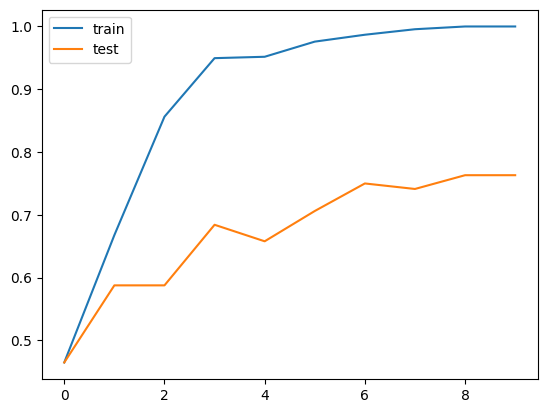

In [7]:
train_acc=[]
test_acc=[]
for i in range(0,10):
    tree = DecisionTree(max_depth=i)
    tree.train(X_train_CNN, y_train_CNN)

    y_pred_train = predict(tree, X_train_CNN)
    accuracy_train = np.mean(y_pred_train == y_train_CNN)
    train_acc.append(accuracy_train)

    y_pred_test = predict(tree, X_test_CNN)
    accuracy_test = np.mean(y_pred_test == y_test_CNN)
    test_acc.append(accuracy_test)

import matplotlib.pyplot as plt
plt.plot(range(0,10),train_acc,label='train')
plt.plot(range(0,10),test_acc,label='test')
plt.legend()
plt.show()

In [8]:
tree_CNN = DecisionTree(max_depth=6)
tree_CNN.train(X_train_CNN, y_train_CNN)

y_pred_CNN = predict(tree_CNN, X_test_CNN)

accuracy_CNN = np.mean(y_pred_CNN == y_test_CNN)
print(f"Test Accuracy for CNN: {accuracy_CNN:.2f}")

y_pred_train_CNN = predict(tree_CNN, X_train_CNN)
accuracy_train_CNN = np.mean(y_pred_train_CNN == y_train_CNN)
print(f"Train Accuracy for CNN: {accuracy_train_CNN:.2f}")


Test Accuracy for CNN: 0.75
Train Accuracy for CNN: 0.99


# Decision Tree on LBP features with LDA

## Loading filtered_LDA_features_dataset and filtering on basis of count of images per person

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

url_filtered_LBP_features_dataset = 'https://raw.githubusercontent.com/AgarwalMayank2/Face_Detection/refs/heads/main/processed_dataset/filtered_LBP_features_dataset.csv' #for CNN limited
df_LBP = pd.read_csv(url_filtered_LBP_features_dataset) # reading url for extracted CNN_features_dataset_limited.csv
df_LBP.drop('Unnamed: 0', axis=1, inplace=True)
#dropping those labels whose number of datapoints are less than 80
# Get the counts of each label
label_counts = df_LBP['256'].value_counts()

# Filter out labels with counts less than 80
labels_to_keep = label_counts[label_counts >= 80].index

# Filter the DataFrame
df_LBP = df_LBP[df_LBP['256'].isin(labels_to_keep)]

df_LBP

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
199,747.0,72.0,433.0,185.0,61.0,6.0,224.0,354.0,392.0,30.0,...,498.0,3001.0,734.0,36.0,578.0,616.0,546.0,453.0,12702.0,George_W_Bush
200,516.0,33.0,438.0,186.0,34.0,2.0,172.0,316.0,243.0,23.0,...,341.0,2309.0,466.0,24.0,354.0,500.0,426.0,516.0,17530.0,George_W_Bush
201,805.0,76.0,366.0,204.0,68.0,10.0,181.0,307.0,537.0,54.0,...,529.0,2171.0,559.0,37.0,413.0,581.0,438.0,537.0,22703.0,George_W_Bush
202,572.0,42.0,304.0,219.0,37.0,3.0,247.0,736.0,587.0,22.0,...,624.0,3621.0,582.0,28.0,273.0,590.0,465.0,315.0,3466.0,George_W_Bush
203,577.0,49.0,403.0,268.0,87.0,4.0,334.0,641.0,494.0,34.0,...,564.0,1535.0,548.0,21.0,284.0,500.0,448.0,280.0,4402.0,George_W_Bush
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,510.0,57.0,358.0,277.0,61.0,2.0,276.0,473.0,325.0,25.0,...,477.0,2048.0,667.0,27.0,395.0,615.0,504.0,392.0,6207.0,Tony_Blair
3335,680.0,57.0,496.0,208.0,69.0,9.0,200.0,365.0,332.0,26.0,...,430.0,2359.0,540.0,37.0,465.0,703.0,660.0,706.0,13144.0,Tony_Blair
3336,800.0,69.0,321.0,224.0,57.0,6.0,225.0,362.0,406.0,48.0,...,488.0,2234.0,723.0,28.0,590.0,850.0,458.0,677.0,13253.0,Tony_Blair
3337,351.0,25.0,197.0,141.0,27.0,4.0,142.0,455.0,247.0,13.0,...,347.0,5927.0,710.0,18.0,413.0,631.0,311.0,399.0,11066.0,Tony_Blair


## Splitting dataframe into train, validation and test in 4:1 ratio

In [10]:
# Separate features and labels
X = df_LBP.iloc[:, :-1]
y = df_LBP.iloc[:, -1]

# Encode labels (alphabetically)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# encoding is benificial as working on numbers is lot easier than working on string

# Ensure stratified split of atleast (64 training, 16 testing per class)
X_train_LBP, X_test_LBP, y_train_LBP, y_test_LBP = train_test_split(X, y_encoded, test_size=1/5, random_state=42, stratify=y_encoded)

# Normalize features
scaler = StandardScaler()
X_train_LBP = scaler.fit_transform(X_train_LBP)
X_test_LBP = scaler.transform(X_test_LBP)

print(f"Dataset size: {df_LBP.shape}")
print(f"After applying LDA => Training size: {X_train_LBP.shape}, Testing size: {X_test_LBP.shape}")


# applying LDA and splitting test into test and val datatypes.

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Apply LDA with at most (number of classes - 1) components
lda = LDA(n_components=min(500, len(set(y_train_CNN)) - 1))
lda.fit_transform(X_train_LBP, y_train_LBP)

X_train_LBP = lda.transform(X_train_LBP)
X_test_LBP = lda.transform(X_test_LBP)

print(f"After applying LDA => Training size: {X_train_LBP.shape}, Testing size: {X_test_LBP.shape}")


Dataset size: (1140, 257)
After applying LDA => Training size: (912, 256), Testing size: (228, 256)
After applying LDA => Training size: (912, 4), Testing size: (228, 4)


## Applying DT on LBP data

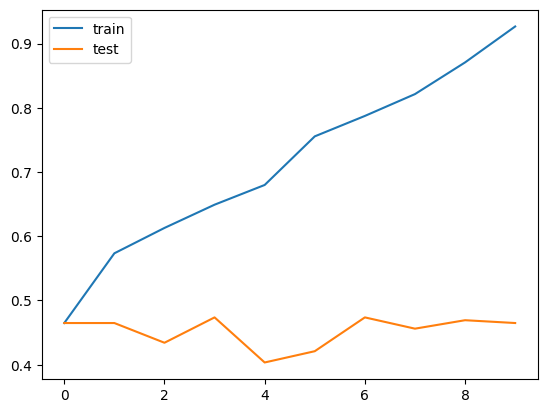

In [11]:
train_acc=[]
test_acc=[]
for i in range(0,10):
    tree = DecisionTree(max_depth=i)
    tree.train(X_train_LBP, y_train_LBP)

    y_pred_train = predict(tree, X_train_LBP)
    accuracy_train = np.mean(y_pred_train == y_train_LBP)
    train_acc.append(accuracy_train)

    y_pred_test = predict(tree, X_test_LBP)
    accuracy_test = np.mean(y_pred_test == y_test_LBP)
    test_acc.append(accuracy_test)

import matplotlib.pyplot as plt
plt.plot(range(0,10),train_acc,label='train')
plt.plot(range(0,10),test_acc,label='test')
plt.legend()
plt.show()

In [12]:
tree_LBP = DecisionTree(max_depth=3)
tree_LBP.train(X_train_LBP, y_train_LBP)

y_pred_LBP = predict(tree_LBP, X_test_LBP)
accuracy_LBP = np.mean(y_pred_LBP == y_test_LBP)
print(f"Test Accuracy for LBP: {accuracy_LBP:.2f}")

y_pred_train_LBP = predict(tree_LBP, X_train_LBP)
accuracy_train_LBP = np.mean(y_pred_train_LBP == y_train_LBP)
print(f"Train Accuracy for LBP: {accuracy_train_LBP:.2f}")


Test Accuracy for LBP: 0.47
Train Accuracy for LBP: 0.65


# Decision Tree on Combined CNN and LBP features with LDA

## Loading filtered CNN and LBP dataset and again filtering on basis of count of images per person

## Splitting dataframe into train, validation and test in 4:1 ratio

## Applying DT on combined data